In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import optimizers, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import *
from keras.utils import Sequence
from keras.optimizers import Adam
import tensorflow.keras.backend as K
from numpy.random import seed

from utils import *
from model import *

# Define paths for figures and models
fig_path = "./figs/FORGE/"
model_path = "./model/"

# Create directories if they do not exist
os.makedirs(fig_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)

2024-12-17 23:26:37.390568: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 23:26:37.390594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 23:26:37.391491: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 23:26:37.396092: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-17 23:26:37.908079: W tensorflow/compiler/tf2

Data shape (original): (960, 2000)


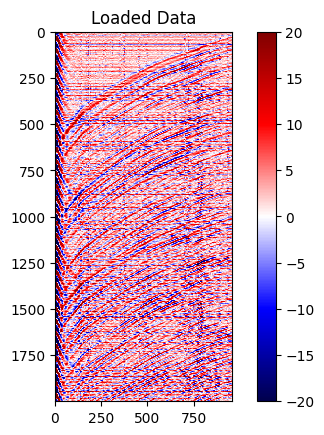

Data shape after patching: (51967, 576)
Data shape after patch selection: (41573, 576)


In [2]:
# Define paths and settings
data_path = './data/'
eq_num = 36
data_name = f'eq-{eq_num}'

# Data and patch parameters
w1, w2 = 24, 24  # Patch dimensions
z1, z2 = 6, 6    # Patch strides
batch = 1024     # Batch size
drop_rate = 0.2  # Drop rate for patch selection

# Load data
data = np.load(f'{data_path}{data_name}.npy')
print(f"Data shape (original): {data.shape}")

# Transpose and visualize data
data = data.T
plt.imshow(data, cmap='seismic', vmin=-20, vmax=20)
plt.title('Loaded Data')
plt.colorbar()
plt.show()

# 2D patching
data_noise = yc_patch(data, w1, w2, z1, z2)

# Patch selection based on kurtosis
data_noise_selected = remove_columns_kurtosis(data_noise, drop_rate)
print(f"Data shape after patching: {data_noise.shape}")
print(f"Data shape after patch selection: {data_noise_selected.shape}")

In [3]:
# Define model parameters
D1 = 128
D2 = D1 // 4  # 32
D3 = D2 // 4  # 8
D4 = D3 // 2  # 2
print(f"Model parameters: D1={D1}, D2={D2}, D3={D3}, D4={D4}")

kernel_size = 3

# Define input sizes
INPUT_SIZE1 = data_noise.shape[0]
INPUT_SIZE2 = data_noise.shape[1]

# Model Input
input_img = Input(shape=(INPUT_SIZE2,))
input_img_expanded = input_img[:, tf.newaxis]

# Encoder
# Level 1
encoded1 = Conv1D(filters=D1, kernel_size=kernel_size, padding='same', name='e1')(input_img_expanded)
encoded1 = BatchNormalization()(encoded1)
encoded1 = PReLU()(encoded1)

encoded1x = Conv1D(filters=D1, kernel_size=kernel_size + 3, padding='same', name='e11')(input_img_expanded)
encoded1x = PReLU()(encoded1x)
encoded1x = concatenate([encoded1x, encoded1], axis=-1)
encoded1x = Dense(D1)(encoded1x)
encoded1x = PReLU()(encoded1x)

skip1 = eca_block(encoded1x)

# Level 2
encoded2 = Conv1D(filters=D2, kernel_size=kernel_size, padding='same', name='e2')(encoded1x)
encoded2 = BatchNormalization()(encoded2)
encoded2 = PReLU()(encoded2)

encoded2x = Conv1D(filters=D2, kernel_size=kernel_size + 3, padding='same', name='e22')(encoded1x)
encoded2x = PReLU()(encoded2x)
encoded2x = concatenate([encoded2x, encoded2], axis=-1)
encoded2x = Dense(D2)(encoded2x)
encoded2x = PReLU()(encoded2x)

skip2 = eca_block(encoded2x)

# Level 3
encoded3 = Conv1D(filters=D3, kernel_size=kernel_size, padding='same', name='e3')(encoded2x)
encoded3 = BatchNormalization()(encoded3)
encoded3 = PReLU()(encoded3)

encoded3x = Conv1D(filters=D3, kernel_size=kernel_size + 3, padding='same', name='e33')(encoded2x)
encoded3x = PReLU()(encoded3x)
encoded3x = concatenate([encoded3x, encoded3], axis=-1)
encoded3x = Dense(D3)(encoded3x)
encoded3x = PReLU()(encoded3x)

skip3 = eca_block(encoded3x)

# Decoder
# Level 3
decoded3 = Conv1D(filters=D3, kernel_size=kernel_size, padding='same', name='d3')(encoded3x)
decoded3 = BatchNormalization()(decoded3)
decoded3 = PReLU()(decoded3)

decoded3x = Conv1D(filters=D3, kernel_size=kernel_size + 3, padding='same', name='d33')(encoded3x)
decoded3x = PReLU()(decoded3x)
decoded3x = concatenate([decoded3x, decoded3], axis=-1)
decoded3x = Dense(D3)(decoded3x)
decoded3x = PReLU()(decoded3x)

decoded3_combined = concatenate([decoded3x, skip3])

# Level 2
decoded2 = Conv1D(filters=D2, kernel_size=kernel_size, padding='same', name='d2')(decoded3_combined)
decoded2 = BatchNormalization()(decoded2)
decoded2 = PReLU()(decoded2)

decoded2x = Conv1D(filters=D2, kernel_size=kernel_size + 3, padding='same', name='d22')(decoded3_combined)
decoded2x = PReLU()(decoded2x)
decoded2x = concatenate([decoded2x, decoded2], axis=-1)
decoded2x = Dense(D2)(decoded2x)
decoded2x = PReLU()(decoded2x)

decoded2_combined = concatenate([decoded2x, skip2])

# Level 1
decoded1 = Conv1D(filters=D1, kernel_size=kernel_size, padding='same', name='d1')(decoded2_combined)
decoded1 = BatchNormalization()(decoded1)
decoded1 = PReLU()(decoded1)

decoded1x = Conv1D(filters=D1, kernel_size=kernel_size + 3, padding='same', name='d11')(decoded2_combined)
decoded1x = PReLU()(decoded1x)
decoded1x = concatenate([decoded1x, decoded1], axis=-1)
decoded1x = Dense(D1)(decoded1x)
decoded1x = PReLU()(decoded1x)

decoded1_combined = concatenate([decoded1x, skip1])

# Output
final_decoded = Conv1D(filters=INPUT_SIZE2 // 3, kernel_size=1, padding='same')(decoded1_combined)
final_decoded = Conv1D(filters=INPUT_SIZE2, kernel_size=1, padding='same')(final_decoded)
final_decoded = Flatten()(final_decoded)

# Build the model
autoencoder = Model(inputs=input_img, outputs=final_decoded)

# Compile the model
optimizer = Adam(learning_rate=0.01)
autoencoder.compile(optimizer=optimizer, loss='MSE')

# Summary of the model
autoencoder.summary()

Model parameters: D1=128, D2=32, D3=8, D4=4
k size 1: 1
k size 2: 1
k size 1: 1
k size 2: 1


2024-12-17 23:26:39.764964: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-17 23:26:39.765202: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-17 23:26:39.794525: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

k size 1: 1
k size 2: 1
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 576)]                0         []                            
                                                                                                  
 tf.__operators__.getitem (  (None, 1, 576)               0         ['input_1[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 e1 (Conv1D)                 (None, 1, 128)               221312    ['tf.__operators__.getitem[0][
                                                                    0]']                          
                                                                      

In [5]:
# Training Parameters
epochs = 50
batch_size = 1024

# Early stopping and model checkpoint callbacks
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(
    filepath=f'{model_path}FORGE_model_{data_name}_p{w1}_s{z1}_drop_{drop_rate}_ep{epochs}.h5',
    monitor='loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# Timing the training process
start_time = time.time()

# Model training
history = autoencoder.fit(
    data_noise_selected,
    data_noise_selected,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    verbose=1,
    validation_split=0.1,
    callbacks=[es, mc]
)

# End timing and print training duration
end_time = time.time()
print(f"Training time for FORGE data: {end_time - start_time:.4f} seconds")

Epoch 1/50


2024-12-17 23:27:08.748560: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-12-17 23:27:09.998464: I external/local_xla/xla/service/service.cc:168] XLA service 0x7753fa2ed1c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-17 23:27:09.998482: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4500, Compute Capability 8.6
2024-12-17 23:27:09.998487: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A4500, Compute Capability 8.6
2024-12-17 23:27:10.001935: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734467230.052616 4180744 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


37/37 [==============================] - ETA: 0s - loss: 472.1742
Epoch 1: loss improved from inf to 472.17416, saving model to ./model/FORGE_model_eq-36_p24_s6_drop_0.2_ep50.h5
37/37 [==============================] - 13s 113ms/step - loss: 472.1742 - val_loss: 410.5247
Epoch 2/50
 1/37 [..............................] - ETA: 0s - loss: 382.2507

/home/g202321530/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 [==============================] - ETA: 0s - loss: 342.5956
Epoch 2: loss improved from 472.17416 to 342.59558, saving model to ./model/FORGE_model_eq-36_p24_s6_drop_0.2_ep50.h5
37/37 [==============================] - 1s 26ms/step - loss: 342.5956 - val_loss: 334.8157
Epoch 3/50
37/37 [==============================] - ETA: 0s - loss: 298.8860
Epoch 3: loss improved from 342.59558 to 298.88605, saving model to ./model/FORGE_model_eq-36_p24_s6_drop_0.2_ep50.h5
37/37 [==============================] - 1s 27ms/step - loss: 298.8860 - val_loss: 306.5370
Epoch 4/50
37/37 [==============================] - ETA: 0s - loss: 377.8353
Epoch 4: loss did not improve from 298.88605
37/37 [==============================] - 1s 23ms/step - loss: 377.8353 - val_loss: 412.1305
Epoch 5/50
37/37 [==============================] - ETA: 0s - loss: 325.0316
Epoch 5: loss did not improve from 298.88605
37/37 [==============================] - 1s 24ms/step - loss: 325.0316 - val_loss: 319.3736
Epoch 6/5